In [313]:
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
from sklearn.preprocessing import MultiLabelBinarizer

seed(1)
import tensorflow
tensorflow.random.set_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ['N','Y']

# **LOAD SECTION**

Select Dataset : chenge value of **data** varieble (between[0-3])

In [314]:
Data = 0

In [315]:
if Data==0 :
  dataset,meta = arff.loadarff('MC1.arff')
  df = pd.DataFrame(dataset)
elif Data == 1:
  dataset,meta = arff.loadarff('MW1.arff')
  df = pd.DataFrame(dataset)
elif Data == 2:
  dataset,meta = arff.loadarff('PC3.arff')
  df = pd.DataFrame(dataset)
elif Data == 3:
  dataset,meta = arff.loadarff('PC4.arff')
  df = pd.DataFrame(dataset)

# **BASE MODEL**

Simple ANN Model

In [316]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Defective', axis=1), df['Defective'], test_size=0.2)
y_train=(pd.get_dummies(y_train))
y_test=(pd.get_dummies(y_test))

features=np.shape(X_train)[1]
model = Sequential()
model.add(Dense(32,activation='ReLU',input_shape=(features,)))
model.add(Dense(16,activation='ReLU'))
model.add(Dense(2,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

base_model = model.fit(X_train, y_train, epochs=10, shuffle=True, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
50/50 [==============================] - 1s 9ms/step - loss: 3305.6963 - accuracy: 0.2302 - val_loss: 56.6004 - val_accuracy: 0.9296
Epoch 2/10
50/50 [==============================] - 0s 3ms/step - loss: 15.8500 - accuracy: 0.9761 - val_loss: 140.0848 - val_accuracy: 0.9749
Epoch 3/10
50/50 [==============================] - 0s 3ms/step - loss: 16.0697 - accuracy: 0.9774 - val_loss: 112.0772 - val_accuracy: 0.9749
Epoch 4/10
50/50 [==============================] - 0s 3ms/step - loss: 13.1698 - accuracy: 0.9774 - val_loss: 95.2020 - val_accuracy: 0.9749
Epoch 5/10
50/50 [==============================] - 0s 4ms/step - loss: 10.1824 - accuracy: 0.9774 - val_loss: 52.6676 - val_accuracy: 0.9749
Epoch 6/10
50/50 [==============================] - 0s 3ms/step - loss: 19.0587 - accuracy: 0.9774 - val_loss: 234.2187 - val_accuracy: 0.9749
Epoch 7/10
50/50 [==============================] - 0s 3ms/step - loss: 194.2595 - accuracy: 0.9774 - val_loss: 596.6884 - val_accuracy: 0.9749

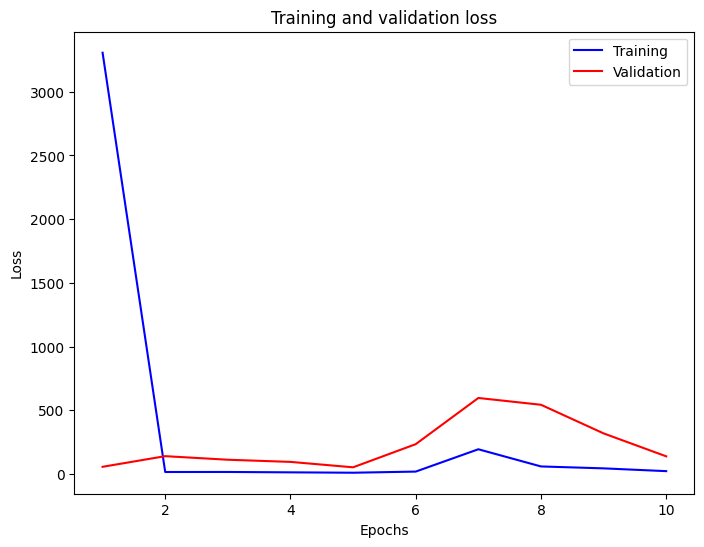

In [327]:
dict = base_model.history
loss_values = dict['loss']
val_loss_values = dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training')
plt.plot(epochs, val_loss_values,'r', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **AUTOENCODER**


In [317]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train_0 = df_train.loc[df['Defective'] == b'N']
df_train_1 = df_train.loc[df['Defective'] == b'Y']
df_train_0_x = df_train_0.drop(['Defective'], axis=1)
df_train_1_x = df_train_1.drop(['Defective'], axis=1)
df_valid_0 = df_valid.loc[df['Defective'] == b'N']
df_valid_1 = df_valid.loc[df['Defective'] == b'Y']
df_valid_0_x = df_valid_0.drop(['Defective'], axis=1)
df_valid_1_x = df_valid_1.drop(['Defective'], axis=1)
df_test_0 = df_test.loc[df['Defective'] == b'N']
df_test_1 = df_test.loc[df['Defective'] == b'Y']
df_test_0_x = df_test_0.drop(['Defective'], axis=1)
df_test_1_x = df_test_1.drop(['Defective'], axis=1)

In [319]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x  = scaler.transform(df_train_0_x)
df_valid_0_x  = scaler.transform(df_valid_0_x)
df_valid_x  = scaler.transform(df_valid.drop(['Defective'], axis = 1))
df_test_0_x  = scaler.transform(df_test_0_x)
df_test_x  = scaler.transform(df_test.drop(['Defective'], axis = 1))

In [320]:
nb_epoch = 100
batch_size = 16
input_dim = df_train_0_x.shape[1] #num of predictor variables,
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 38)]              0         
                                                                 
 dense_132 (Dense)           (None, 32)                1248      
                                                                 
 dense_133 (Dense)           (None, 16)                528       
                                                                 
 dense_134 (Dense)           (None, 16)                272       
                                                                 
 dense_135 (Dense)           (None, 32)                544       
                                                                 
 dense_136 (Dense)           (None, 38)                1254      
                                                                 
Total params: 3846 (15.02 KB)
Trainable params: 3846 (15.0

In [321]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

history = autoencoder.fit(df_train_0_x , df_train_0_x ,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x , df_valid_0_x ),
                    verbose=1).history

Epoch 1/100
78/78 [==============================] - 3s 8ms/step - loss: 0.7569 - accuracy: 0.0562 - val_loss: 0.4770 - val_accuracy: 0.0647
Epoch 2/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5051 - accuracy: 0.1188 - val_loss: 0.3917 - val_accuracy: 0.2168
Epoch 3/100
78/78 [==============================] - 0s 6ms/step - loss: 0.4121 - accuracy: 0.2504 - val_loss: 0.3376 - val_accuracy: 0.3107
Epoch 4/100
78/78 [==============================] - 0s 4ms/step - loss: 0.3583 - accuracy: 0.3379 - val_loss: 0.3121 - val_accuracy: 0.3560
Epoch 5/100
78/78 [==============================] - 0s 4ms/step - loss: 0.3184 - accuracy: 0.3748 - val_loss: 0.2751 - val_accuracy: 0.3819
Epoch 6/100
78/78 [==============================] - 0s 5ms/step - loss: 0.2739 - accuracy: 0.4358 - val_loss: 0.2540 - val_accuracy: 0.5178
Epoch 7/100
78/78 [==============================] - 0s 5ms/step - loss: 0.2376 - accuracy: 0.4896 - val_loss: 0.2291 - val_accuracy: 0.4951
Epoch 8/100
7

10/10 [==============================] - 0s 3ms/step


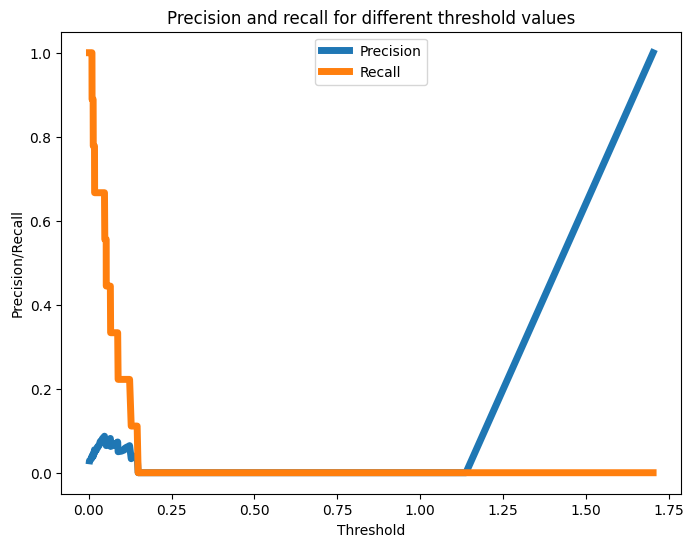

In [322]:
valid_x_predictions = autoencoder.predict(df_valid_x )
mse = np.mean(np.power(df_valid_x  - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['Defective']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(MultiLabelBinarizer().fit_transform(error_df.True_class).argmax(axis=1), error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

13/13 [==============================] - 0s 2ms/step


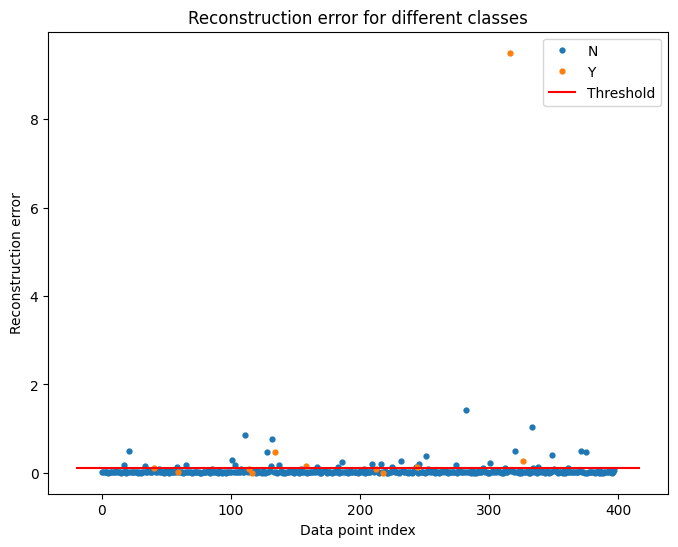

In [323]:
test_x_predictions = autoencoder.predict(df_test_x )
mse = np.mean(np.power(df_test_x  - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['Defective']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.1
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "N" if name == (b'N') else "Y")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

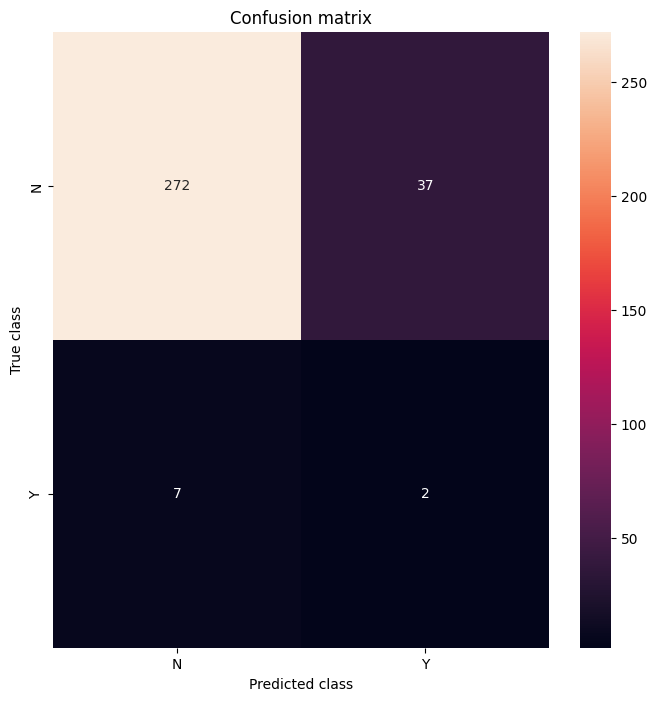

In [324]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(MultiLabelBinarizer().fit_transform(error_df.True_class).argmax(axis=1), pred_y)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

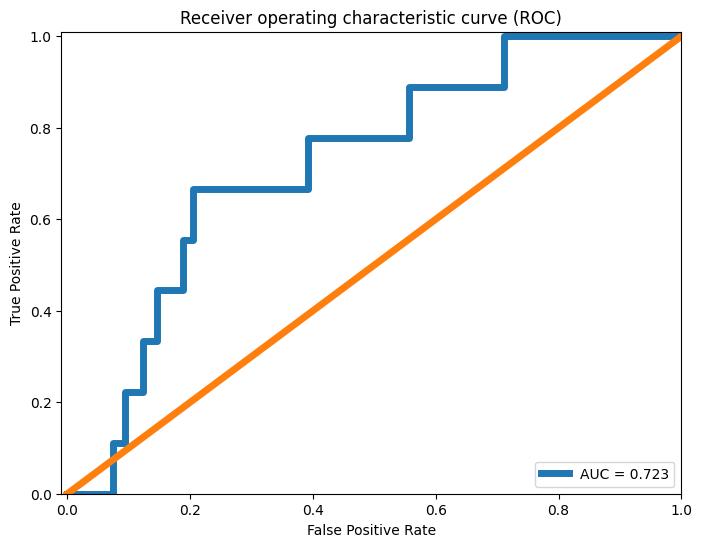

In [325]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(MultiLabelBinarizer().fit_transform(error_df.True_class).argmax(axis=1), error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()